# 第8章: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow import keras

## 70. 単語ベクトルの和による特徴量

### データ準備

In [2]:
# 学習データ，検証データ，評価データ読み込み
df_train = pd.read_csv('train.txt', sep='\t')
df_valid = pd.read_csv('valid.txt', sep='\t')
df_test = pd.read_csv('test.txt', sep='\t')
df_test.head()

,CATEGORY,TITLE
0,b,Vodafone's Service Revenue Falls as European M...
1,e,"So, Tupac Shakur's Final Words Were A Big ""F*C..."
2,t,Elephants really are intelligent: Creatures ca...
3,t,FTC says Snapchat deceived customers over 'dis...
4,b,UPDATE 3-GM says facing multiple probes into r...


### ラベルベクトル作成

In [5]:
def trans_label_int(label: str) -> int:
    if label == 'b':
        return 0
    elif label == 't':
        return 1
    elif label == 'e':
        return 2
    elif label == 'm':
        return 3

print(trans_label_int(label='b'))
print(trans_label_int(label='t'))
print(trans_label_int(label='e'))
print(trans_label_int(label='m'))

0
1
2
3


In [11]:
# ラベルを整数に変換
y_train = (
    df_train
    .loc[:, 'CATEGORY']
    .apply(trans_label_int)
    .values
)
y_valid = (
    df_valid
    .loc[:, 'CATEGORY']
    .apply(trans_label_int)
    .values
)
y_test = (
    df_test
    .loc[:, 'CATEGORY']
    .apply(trans_label_int)
    .values
)

In [13]:
np.save('70_y_train.npy', y_train)
np.save('70_y_valid.npy', y_valid)
np.save('70_y_test.npy', y_test)

### 特徴量行列作成

#### 単語の出現回数取得

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# 試しに動かす
vectorizer = CountVectorizer()

tes = pd.DataFrame([
    'This is my car',
    'This is my friend',
    'This is my English book',
], columns=['TITLE'])

tes_vector = vectorizer.fit_transform(tes['TITLE'].tolist())

print(vectorizer.get_feature_names())
print(tes_vector.toarray())

['book', 'car', 'english', 'friend', 'is', 'my', 'this']
[[0 1 0 0 1 1 1]
 [0 0 0 1 1 1 1]
 [1 0 1 0 1 1 1]]


In [5]:
vectorizer = CountVectorizer()
# 計算 & 変換
train_data = vectorizer.fit_transform(df_train['TITLE'].tolist()).toarray()
feature_names = vectorizer.get_feature_names()
# 変換
valid_data = vectorizer.transform(df_valid['TITLE'].tolist()).toarray()
test_data = vectorizer.transform(df_test['TITLE'].tolist()).toarray()

In [19]:
type(feature_names)

list

In [31]:
def trans_title_word_cnt(array: np.ndarray, columns: list) -> pd.DataFrame:
    """
    入力
    array: 単語の出現回数
    columns: 単語リスト
    出力
    データフレーム
    - Title No
    - 単語
    - 出現回数
    """
    df = (
        pd.DataFrame(array, columns=columns)
        .applymap(lambda x: np.nan if x == 0 else x)
        .stack()
        .reset_index()
    )
    df.columns = ['No', 'word', 'cnt']
    return df

tes_array = np.array([[0, 1, 2], [3, 4, 5]])
tes_columns = ['a', 'b', 'c']
trans_title_word_cnt(array=tes_array, columns=tes_columns)

,No,word,cnt
0,0,b,1.0
1,0,c,2.0
2,1,a,3.0
3,1,b,4.0
4,1,c,5.0


In [32]:
# 縦持ちのDataFrame
df_train_word_count = trans_title_word_cnt(array=train_data, columns=feature_names)
df_valid_word_count = trans_title_word_cnt(array=valid_data, columns=feature_names)
df_test_word_count = trans_title_word_cnt(array=test_data, columns=feature_names)

In [33]:
df_train_word_count.head()

,No,word,cnt
0,0,abs,1.0
1,0,auto,1.0
2,0,consumer,1.0
3,0,criteria,1.0
4,0,emea,1.0


#### タイトルごとの単語ベクトル平均値算出

In [34]:
from gensim.models import KeyedVectors

In [35]:
# 学習済み単語ベクトル
vector_path = os.path.join(os.getcwd(), '../data/GoogleNews-vectors-negative300.bin')

In [36]:
# 読み込み
wv_from_bin = KeyedVectors.load_word2vec_format(vector_path, binary=True)

In [107]:
# word列の単語ベクトルを返す
def get_word_vector(row, vector) -> pd.DataFrame:
    try:
        return vector[row['word']] * row['cnt']
    except KeyError:
        ret_len = len(vector['an']) # 適当な単語で長さ取得
        return np.zeros(ret_len)

(
    pd.DataFrame(
        [
            [1, 'shakur', 1.0],
            [0, 'abs', 1.0],
            [0, 'auto', 1.0],
            [1, 'auto', 2.0],
        ],
        columns=['No', 'word', 'cnt']
    )
    .apply(get_word_vector, axis=1, result_type='expand', vector=wv_from_bin)
)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.108887,0.029907,0.373047,0.371094,-0.038818,0.283203,-0.051025,-0.141602,-0.229492,0.097168,...,0.018677,-0.166992,-0.267578,-0.345703,0.322266,-0.024048,0.074219,0.072754,-0.308594,-0.190430
2,0.166992,0.201172,0.086914,0.189453,-0.137695,0.206055,0.042236,0.081543,0.126953,-0.037598,...,-0.310547,-0.038086,0.188477,-0.100586,-0.038330,0.149414,-0.176758,0.353516,-0.000847,-0.357422
3,0.333984,0.402344,0.173828,0.378906,-0.275391,0.412109,0.084473,0.163086,0.253906,-0.075195,...,-0.621094,-0.076172,0.376953,-0.201172,-0.076660,0.298828,-0.353516,0.707031,-0.001694,-0.714844


In [108]:
def concat_df_wordvector(df: pd.DataFrame, vector) -> pd.DataFrame:
    return pd.concat(
        [
            df,
            df.apply(
                get_word_vector,
                axis=1,
                result_type='expand',
                vector=wv_from_bin
            )
        ],
        axis=1
    )

tes_df = (
    pd.DataFrame(
        [
            [1, 'shakur', 1.0],
            [0, 'abs', 1.0],
            [0, 'auto', 1.0],
            [1, 'auto', 2.0],
        ],
        columns=['No', 'word', 'cnt']
    )
)
concat_df_wordvector(df=tes_df, vector=wv_from_bin)

,No,word,cnt,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,1,shakur,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,abs,1.0,0.108887,0.029907,0.373047,0.371094,-0.038818,0.283203,-0.051025,...,0.018677,-0.166992,-0.267578,-0.345703,0.322266,-0.024048,0.074219,0.072754,-0.308594,-0.190430
2,0,auto,1.0,0.166992,0.201172,0.086914,0.189453,-0.137695,0.206055,0.042236,...,-0.310547,-0.038086,0.188477,-0.100586,-0.038330,0.149414,-0.176758,0.353516,-0.000847,-0.357422
3,1,auto,2.0,0.333984,0.402344,0.173828,0.378906,-0.275391,0.412109,0.084473,...,-0.621094,-0.076172,0.376953,-0.201172,-0.076660,0.298828,-0.353516,0.707031,-0.001694,-0.714844


In [109]:
# 縦持ちデータフレームから、
def calculate_titile_wordvector(df: pd.DataFrame, vector) -> pd.DataFrame:
    return (
        concat_df_wordvector(df=df, vector=wv_from_bin)
        .drop(['word', 'cnt'], axis=1)
        .groupby('No')
        .mean()
    )

tes_df = (
    pd.DataFrame(
        [
            [0, 'abs', 1.0],
            [0, 'auto', 1.0],
            [1, 'auto', 2.0],
            [1, 'shakur', 1.0]
        ],
        columns=['No', 'word', 'cnt']
    )
)

calculate_titile_wordvector(df=tes_df, vector=wv_from_bin)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
No,,,,,,,,,,,,,,,,,,,,,
0,0.137939,0.115540,0.229980,0.280273,-0.088257,0.244629,-0.004395,-0.030029,-0.051270,0.029785,...,-0.145935,-0.102539,-0.039551,-0.223145,0.141968,0.062683,-0.051270,0.213135,-0.154720,-0.273926
1,0.166992,0.201172,0.086914,0.189453,-0.137695,0.206055,0.042236,0.081543,0.126953,-0.037598,...,-0.310547,-0.038086,0.188477,-0.100586,-0.038330,0.149414,-0.176758,0.353516,-0.000847,-0.357422


In [111]:
# titleごとの平均単語ベクトル
df_train_features = calculate_titile_wordvector(df=df_train_word_count, vector=wv_from_bin)
df_valid_features = calculate_titile_wordvector(df=df_valid_word_count, vector=wv_from_bin)
df_test_features = calculate_titile_wordvector(df=df_test_word_count, vector=wv_from_bin)

In [115]:
np.save('70_x_train.npy', df_train_features.values)
np.save('70_x_valid.npy', df_valid_features.values)
np.save('70_x_test.npy', df_test_features.values)

## 71. 単層ニューラルネットワークによる予測

In [4]:
# 特徴量行列読み込み
x_train = np.load('70_x_train.npy')
x_valid = np.load('70_x_valid.npy')
x_test = np.load('70_x_test.npy')

In [5]:
# ラベルベクトル読み込み
y_train = np.load('70_y_train.npy')
y_valid = np.load('70_y_valid.npy')
y_test = np.load('70_y_test.npy')

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(300,)),
  tf.keras.layers.Dense(4)
])

In [6]:
model.variables

[<tf.Variable 'dense/kernel:0' shape=(300, 4) dtype=float32, numpy=
 array([[-0.02405263,  0.05797277,  0.08333877, -0.11684883],
        [-0.04438991,  0.0755439 ,  0.12357919, -0.07688701],
        [ 0.03131263, -0.00477631, -0.05933721, -0.03981956],
        ...,
        [-0.04004994, -0.05251788,  0.01854898,  0.13610975],
        [-0.10553957,  0.12458913, -0.06835857,  0.03758542],
        [ 0.06262796,  0.09886761,  0.10989659, -0.04294457]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

In [7]:
y_pred_1 = model(x_train[:1])
y_pred_1

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01577283,  0.17237882,  0.09412156, -0.11099218]],
      dtype=float32)>

In [8]:
y_tilde_1 = tf.nn.softmax(y_pred_1)
y_tilde_1

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.23627536, 0.28518826, 0.26372114, 0.21481529]], dtype=float32)>

In [9]:
Y_pred = model(x_train[:4])
Y_pred

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[-0.01577287,  0.17237884,  0.09412153, -0.11099222],
       [ 0.01490638,  0.0766397 ,  0.06239213,  0.0344914 ],
       [-0.11694963,  0.15236321,  0.10474639, -0.0472367 ],
       [-0.00807093,  0.2212768 ,  0.10077907,  0.04352715]],
      dtype=float32)>

In [10]:
Y_tilde = tf.nn.softmax(Y_pred)
Y_tilde

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.23627533, 0.28518826, 0.26372114, 0.21481527],
       [0.2420084 , 0.25741917, 0.25377756, 0.24679486],
       [0.21600804, 0.2827685 , 0.2696195 , 0.2316039 ],
       [0.22595158, 0.2841972 , 0.2519349 , 0.23791625]], dtype=float32)>

## 72. 損失と勾配の計算

### クロスエントロピー損失

In [7]:
# クロスエントロピー損失を求める関数
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [12]:
loss_fn(y_train[:1], y_tilde_1).numpy()

1.4003756

In [13]:
loss_fn(y_train[:4], Y_tilde).numpy()

1.3970408

### 行列Wに対する勾配

In [14]:
x = tf.Variable(x_train[:1])
with tf.GradientTape() as tape:
    y = tf.nn.softmax(model(x))

In [15]:
tape.gradient(y, x)

<tf.Tensor: shape=(1, 300), dtype=float64, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [3]:
# 特徴量行列読み込み
x_train = np.load('70_x_train.npy')
x_valid = np.load('70_x_valid.npy')
x_test = np.load('70_x_test.npy')

In [4]:
# ラベルベクトル読み込み
y_train = np.load('70_y_train.npy')
y_valid = np.load('70_y_valid.npy')
y_test = np.load('70_y_test.npy')

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(300,)),
  tf.keras.layers.Dense(4)
])

In [6]:
# クロスエントロピー損失を求める関数
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [7]:
model.compile(optimizer='SGD',
              loss=loss_fn,
              metrics=['accuracy'])

In [8]:
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
334/334 [==============================] - 0s 505us/step - loss: 1.2831 - accuracy: 0.5603
Epoch 2/100
334/334 [==============================] - 0s 501us/step - loss: 1.0793 - accuracy: 0.7382
Epoch 3/100
334/334 [==============================] - 0s 522us/step - loss: 1.0146 - accuracy: 0.7528
Epoch 4/100
334/334 [==============================] - 0s 483us/step - loss: 0.9597 - accuracy: 0.7618
Epoch 5/100
334/334 [==============================] - 0s 495us/step - loss: 0.9322 - accuracy: 0.7624
Epoch 6/100
334/334 [==============================] - 0s 523us/step - loss: 0.9094 - accuracy: 0.7543
Epoch 7/100
334/334 [==============================] - 0s 472us/step - loss: 0.8652 - accuracy: 0.7673
Epoch 8/100
334/334 [==============================] - 0s 526us/step - loss: 0.8480 - accuracy: 0.7642
Epoch 9/100
334/334 [==============================] - 0s 544us/step - loss: 0.8224 - accuracy: 0.7684
Epoch 10/100
334/334 [==============================] - 0s 495us/step - l

## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [9]:
# 学習データの正解率
model.evaluate(x_train, y_train, verbose=2)

334/334 - 0s - loss: 0.4530 - accuracy: 0.8523


[0.4530147314071655, 0.8523238301277161]

In [10]:
# 評価データの正解率
model.evaluate(x_test, y_test, verbose=2)

42/42 - 0s - loss: 0.4538 - accuracy: 0.8598


[0.4538155496120453, 0.8598200678825378]

## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [11]:
# 特徴量行列読み込み
x_train = np.load('70_x_train.npy')
x_valid = np.load('70_x_valid.npy')
x_test = np.load('70_x_test.npy')

In [12]:
# ラベルベクトル読み込み
y_train = np.load('70_y_train.npy')
y_valid = np.load('70_y_valid.npy')
y_test = np.load('70_y_test.npy')

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(300,)),
  tf.keras.layers.Dense(4)
])

In [14]:
# クロスエントロピー損失を求める関数
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [16]:
model.compile(optimizer='SGD',
              loss=loss_fn,
              metrics=['accuracy'])

In [17]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=50,
    validation_data=(x_valid, y_valid)
)

Epoch 1/50
334/334 [==============================] - 1s 1ms/step - loss: 1.3411 - accuracy: 0.3319 - val_loss: 1.1300 - val_accuracy: 0.7009
Epoch 2/50
334/334 [==============================] - 0s 706us/step - loss: 1.1113 - accuracy: 0.6957 - val_loss: 1.0338 - val_accuracy: 0.7504
Epoch 3/50
334/334 [==============================] - 0s 664us/step - loss: 1.0223 - accuracy: 0.7509 - val_loss: 0.9766 - val_accuracy: 0.7609
Epoch 4/50
334/334 [==============================] - 0s 616us/step - loss: 0.9778 - accuracy: 0.7560 - val_loss: 0.9336 - val_accuracy: 0.7661
Epoch 5/50
334/334 [==============================] - 0s 622us/step - loss: 0.9357 - accuracy: 0.7560 - val_loss: 0.8988 - val_accuracy: 0.7699
Epoch 6/50
334/334 [==============================] - 0s 646us/step - loss: 0.9077 - accuracy: 0.7603 - val_loss: 0.8694 - val_accuracy: 0.7699
Epoch 7/50
334/334 [==============================] - 0s 682us/step - loss: 0.8780 - accuracy: 0.7634 - val_loss: 0.8442 - val_accuracy: 0

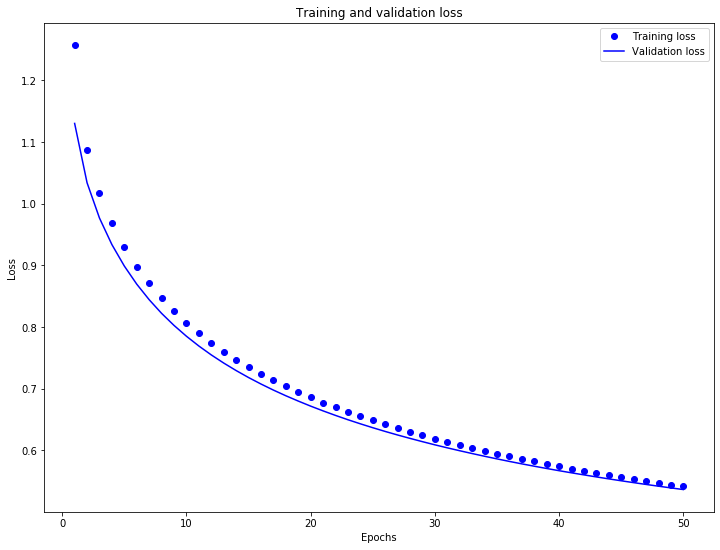

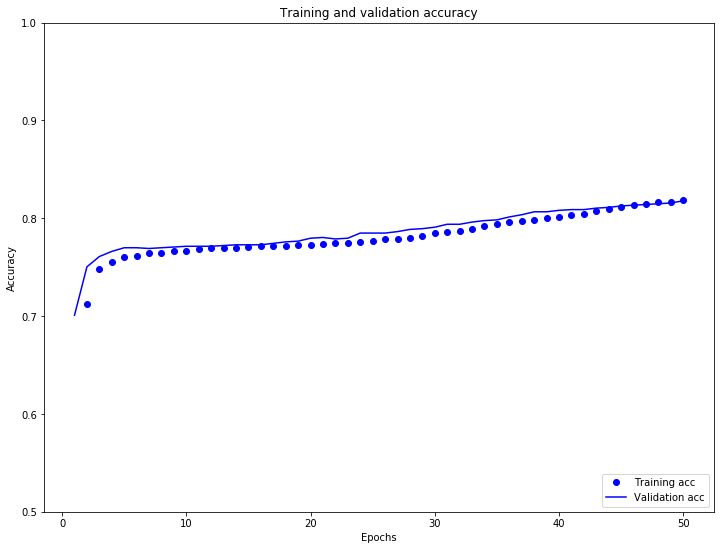

In [18]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [11]:
# 特徴量行列読み込み
x_train = np.load('70_x_train.npy')
x_valid = np.load('70_x_valid.npy')
x_test = np.load('70_x_test.npy')

In [12]:
# ラベルベクトル読み込み
y_train = np.load('70_y_train.npy')
y_valid = np.load('70_y_valid.npy')
y_test = np.load('70_y_test.npy')

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(300,)),
  tf.keras.layers.Dense(4)
])

In [14]:
# クロスエントロピー損失を求める関数
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [16]:
model.compile(optimizer='SGD',
              loss=loss_fn,
              metrics=['accuracy'])

In [25]:
# ファイル名に(`str.format`を使って)エポック数を埋め込む
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [26]:
# チェックポイントコールバックを作る
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=False,
                                                 verbose=1,
                                                 save_freq=1
                                                )

In [27]:
# `checkpoint_path` フォーマットで重みを保存
model.save_weights(checkpoint_path.format(epoch=0))

In [28]:
model.fit(
    x=x_train,
    y=y_train,
    epochs=3,
    validation_data=(x_valid, y_valid),
    callbacks=[cp_callback]
)

Epoch 1/3
  1/334 [..............................] - ETA: 0s - loss: 0.6734 - accuracy: 0.8125
Epoch 00001: saving model to training_2\cp-0001.ckpt
INFO:tensorflow:Assets written to: training_2\cp-0001.ckpt\assets
  2/334 [..............................] - ETA: 1:55 - loss: 0.7054 - accuracy: 0.7812
Epoch 00001: saving model to training_2\cp-0001.ckpt
INFO:tensorflow:Assets written to: training_2\cp-0001.ckpt\assets
  3/334 [..............................] - ETA: 1:49 - loss: 0.6274 - accuracy: 0.8333
Epoch 00001: saving model to training_2\cp-0001.ckpt
INFO:tensorflow:Assets written to: training_2\cp-0001.ckpt\assets
  4/334 [..............................] - ETA: 1:51 - loss: 0.6036 - accuracy: 0.8438
Epoch 00001: saving model to training_2\cp-0001.ckpt
INFO:tensorflow:Assets written to: training_2\cp-0001.ckpt\assets
  5/334 [..............................] - ETA: 1:49 - loss: 0.6191 - accuracy: 0.8375
Epoch 00001: saving model to training_2\cp-0001.ckpt
INFO:tensorflow:Assets writt

## 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [19]:
# 特徴量行列読み込み
x_train = np.load('70_x_train.npy')
x_valid = np.load('70_x_valid.npy')
x_test = np.load('70_x_test.npy')

In [20]:
# ラベルベクトル読み込み
y_train = np.load('70_y_train.npy')
y_valid = np.load('70_y_valid.npy')
y_test = np.load('70_y_test.npy')

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(300,)),
  tf.keras.layers.Dense(4)
])

In [22]:
# クロスエントロピー損失を求める関数
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [23]:
model.compile(optimizer='SGD',
              loss=loss_fn,
              metrics=['accuracy'])

In [24]:
batch_size = 1
model.fit(x_train, y_train, epochs=5, batch_size=batch_size)

Epoch 1/5
10672/10672 [==============================] - 5s 482us/step - loss: 0.9077 - accuracy: 0.7355
Epoch 2/5
10672/10672 [==============================] - 5s 483us/step - loss: 0.5736 - accuracy: 0.8027
Epoch 3/5
10672/10672 [==============================] - 5s 485us/step - loss: 0.4878 - accuracy: 0.8413
Epoch 4/5
10672/10672 [==============================] - 5s 486us/step - loss: 0.4548 - accuracy: 0.8516
Epoch 5/5
10672/10672 [==============================] - 5s 488us/step - loss: 0.4207 - accuracy: 0.8655


In [25]:
batch_size = 2
model.fit(x_train, y_train, epochs=5, batch_size=batch_size)

Epoch 1/5
5336/5336 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.86 - 4s 785us/step - loss: 0.4066 - accuracy: 0.8677
Epoch 2/5
5336/5336 [==============================] - 5s 846us/step - loss: 0.3990 - accuracy: 0.8708
Epoch 3/5
5336/5336 [==============================] - 4s 781us/step - loss: 0.3929 - accuracy: 0.8716
Epoch 4/5
5336/5336 [==============================] - 4s 782us/step - loss: 0.3875 - accuracy: 0.8730
Epoch 5/5
5336/5336 [==============================] - 4s 793us/step - loss: 0.3823 - accuracy: 0.8750


In [26]:
batch_size = 4
model.fit(x_train, y_train, epochs=5, batch_size=batch_size)

Epoch 1/5
2668/2668 [==============================] - 2s 829us/step - loss: 0.3786 - accuracy: 0.8757
Epoch 2/5
2668/2668 [==============================] - 2s 828us/step - loss: 0.3764 - accuracy: 0.8767
Epoch 3/5
2668/2668 [==============================] - 2s 832us/step - loss: 0.3744 - accuracy: 0.8762
Epoch 4/5
2668/2668 [==============================] - 2s 814us/step - loss: 0.3724 - accuracy: 0.8761
Epoch 5/5
2668/2668 [==============================] - 2s 811us/step - loss: 0.3706 - accuracy: 0.8770


In [27]:
batch_size = 8
model.fit(x_train, y_train, epochs=5, batch_size=batch_size)

Epoch 1/5
1334/1334 [==============================] - 1s 845us/step - loss: 0.3690 - accuracy: 0.8780
Epoch 2/5
1334/1334 [==============================] - 1s 824us/step - loss: 0.3681 - accuracy: 0.8779
Epoch 3/5
1334/1334 [==============================] - 1s 802us/step - loss: 0.3673 - accuracy: 0.8780
Epoch 4/5
1334/1334 [==============================] - 1s 829us/step - loss: 0.3664 - accuracy: 0.8786
Epoch 5/5
1334/1334 [==============================] - 1s 829us/step - loss: 0.3656 - accuracy: 0.8787


In [28]:
batch_size = 16
model.fit(x_train, y_train, epochs=5, batch_size=batch_size)

Epoch 1/5
667/667 [==============================] - 1s 866us/step - loss: 0.3649 - accuracy: 0.8785
Epoch 2/5
667/667 [==============================] - 1s 863us/step - loss: 0.3645 - accuracy: 0.8782
Epoch 3/5
667/667 [==============================] - 1s 851us/step - loss: 0.3641 - accuracy: 0.8787
Epoch 4/5
667/667 [==============================] - 1s 836us/step - loss: 0.3637 - accuracy: 0.8790
Epoch 5/5
667/667 [==============================] - 1s 844us/step - loss: 0.3633 - accuracy: 0.8785


## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [29]:
print("利用できるGPUはあるか: "),
print(tf.config.experimental.list_physical_devices("GPU"))

利用できるGPUはあるか: 
[]


## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [3]:
# 特徴量行列読み込み
x_train = np.load('70_x_train.npy')
x_valid = np.load('70_x_valid.npy')
x_test = np.load('70_x_test.npy')

In [4]:
# ラベルベクトル読み込み
y_train = np.load('70_y_train.npy')
y_valid = np.load('70_y_valid.npy')
y_test = np.load('70_y_test.npy')

In [5]:
# クロスエントロピー損失を求める関数
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### 1. バイアス項なし

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(300,)),
    tf.keras.layers.Dense(4, use_bias=False)
])

In [22]:
model.compile(optimizer='SGD',
              loss=loss_fn,
              metrics=['accuracy'])

In [23]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    validation_data=(x_valid, y_valid)
)

Epoch 1/10
334/334 [==============================] - 0s 949us/step - loss: 1.3661 - accuracy: 0.3482 - val_loss: 1.2129 - val_accuracy: 0.6859
Epoch 2/10
334/334 [==============================] - 0s 685us/step - loss: 1.1885 - accuracy: 0.6973 - val_loss: 1.0876 - val_accuracy: 0.7451
Epoch 3/10
334/334 [==============================] - 0s 709us/step - loss: 1.0793 - accuracy: 0.7468 - val_loss: 1.0073 - val_accuracy: 0.7624
Epoch 4/10
334/334 [==============================] - 0s 721us/step - loss: 0.9994 - accuracy: 0.7640 - val_loss: 0.9513 - val_accuracy: 0.7676
Epoch 5/10
334/334 [==============================] - 0s 694us/step - loss: 0.9540 - accuracy: 0.7601 - val_loss: 0.9095 - val_accuracy: 0.7706
Epoch 6/10
334/334 [==============================] - 0s 652us/step - loss: 0.9143 - accuracy: 0.7622 - val_loss: 0.8766 - val_accuracy: 0.7736
Epoch 7/10
334/334 [==============================] - 0s 658us/step - loss: 0.8822 - accuracy: 0.7635 - val_loss: 0.8496 - val_accuracy:

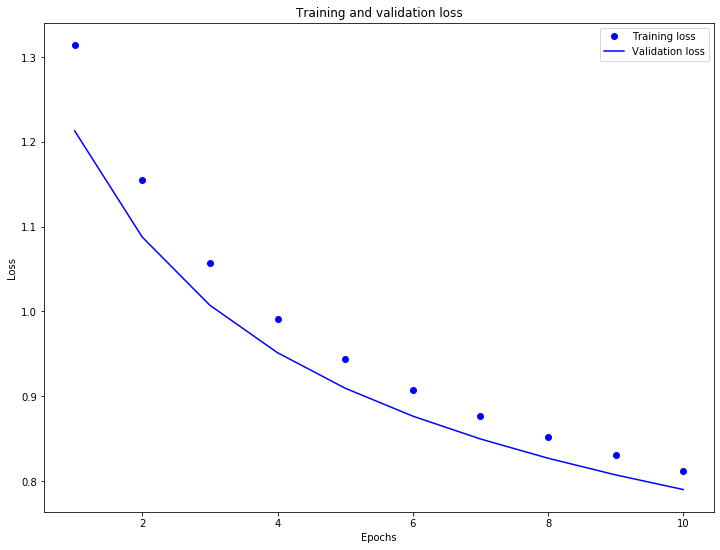

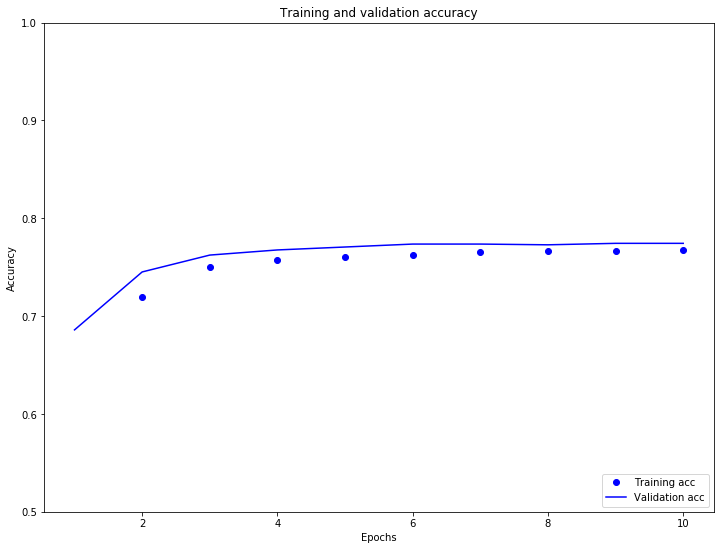

In [24]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

### 2. バイアス項あり

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(300,)),
    tf.keras.layers.Dense(4, use_bias=True)
])

In [16]:
model.compile(optimizer='SGD',
              loss=loss_fn,
              metrics=['accuracy'])

In [17]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    validation_data=(x_valid, y_valid)
)

Epoch 1/10
334/334 [==============================] - 1s 1ms/step - loss: 1.2624 - accuracy: 0.5830 - val_loss: 1.0931 - val_accuracy: 0.7189
Epoch 2/10
334/334 [==============================] - 0s 769us/step - loss: 1.0771 - accuracy: 0.7251 - val_loss: 1.0104 - val_accuracy: 0.7429
Epoch 3/10
334/334 [==============================] - 0s 655us/step - loss: 1.0112 - accuracy: 0.7444 - val_loss: 0.9592 - val_accuracy: 0.7564
Epoch 4/10
334/334 [==============================] - 0s 673us/step - loss: 0.9514 - accuracy: 0.7619 - val_loss: 0.9202 - val_accuracy: 0.7594
Epoch 5/10
334/334 [==============================] - 0s 688us/step - loss: 0.9190 - accuracy: 0.7636 - val_loss: 0.8880 - val_accuracy: 0.7609
Epoch 6/10
334/334 [==============================] - 0s 688us/step - loss: 0.8919 - accuracy: 0.7637 - val_loss: 0.8607 - val_accuracy: 0.7654
Epoch 7/10
334/334 [==============================] - 0s 703us/step - loss: 0.8694 - accuracy: 0.7602 - val_loss: 0.8370 - val_accuracy: 0

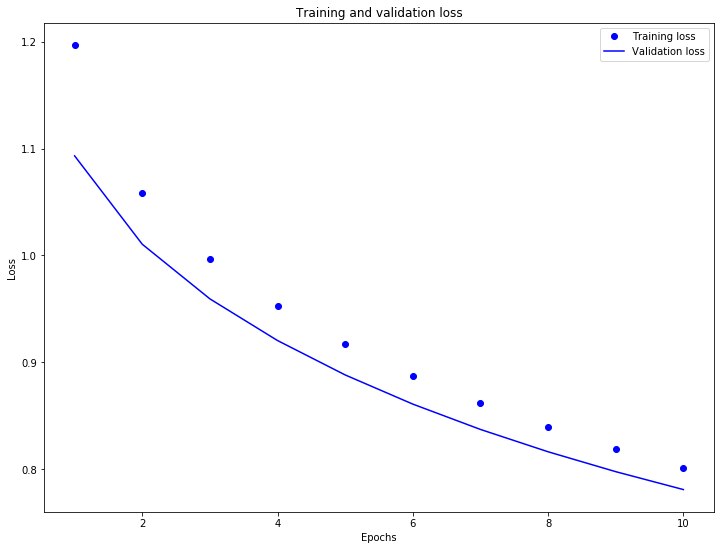

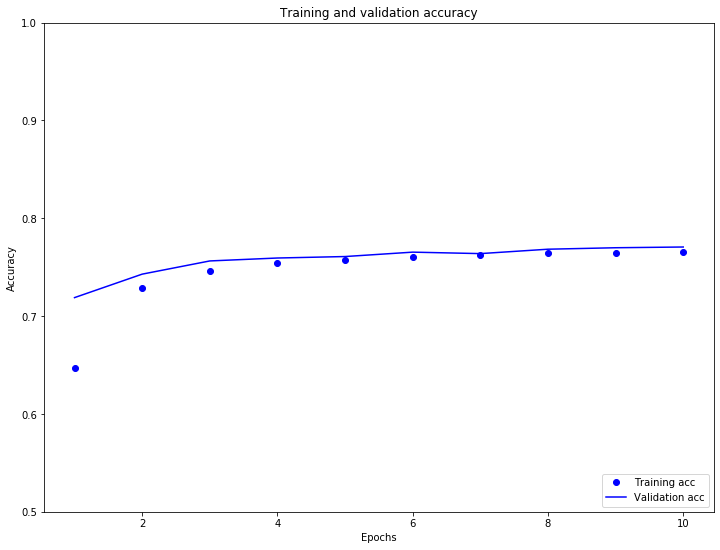

In [20]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

### 3. 多層化

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(300,)),
    tf.keras.layers.Dense(16, use_bias=True), # 追加,16はなんとなく4の二乗
    tf.keras.layers.Dense(4, use_bias=True)
])

In [26]:
model.compile(optimizer='SGD',
              loss=loss_fn,
              metrics=['accuracy'])

In [27]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    validation_data=(x_valid, y_valid)
)

Epoch 1/10
334/334 [==============================] - 0s 949us/step - loss: 1.2254 - accuracy: 0.5133 - val_loss: 1.0659 - val_accuracy: 0.7181
Epoch 2/10
334/334 [==============================] - 0s 721us/step - loss: 1.0470 - accuracy: 0.7332 - val_loss: 0.9547 - val_accuracy: 0.7526
Epoch 3/10
334/334 [==============================] - 0s 664us/step - loss: 0.9216 - accuracy: 0.7609 - val_loss: 0.8447 - val_accuracy: 0.7661
Epoch 4/10
334/334 [==============================] - 0s 646us/step - loss: 0.8172 - accuracy: 0.7706 - val_loss: 0.7577 - val_accuracy: 0.7661
Epoch 5/10
334/334 [==============================] - 0s 664us/step - loss: 0.7361 - accuracy: 0.7717 - val_loss: 0.6954 - val_accuracy: 0.7706
Epoch 6/10
334/334 [==============================] - 0s 700us/step - loss: 0.6833 - accuracy: 0.7695 - val_loss: 0.6509 - val_accuracy: 0.7766
Epoch 7/10
334/334 [==============================] - 0s 673us/step - loss: 0.6350 - accuracy: 0.7758 - val_loss: 0.6170 - val_accuracy:

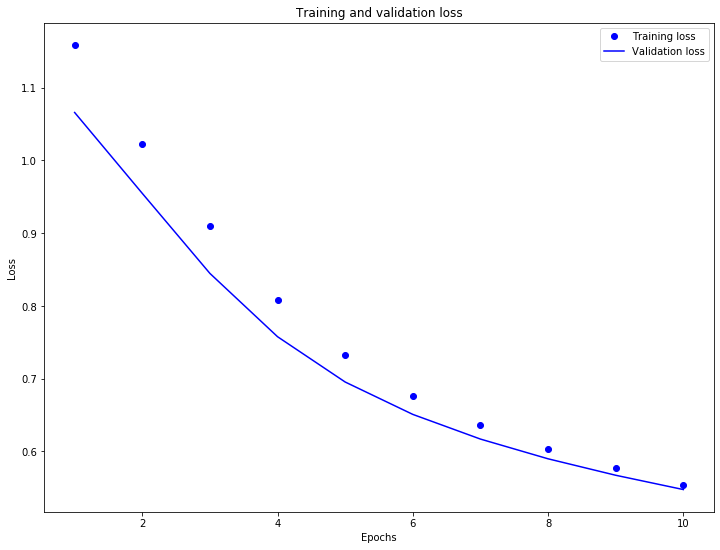

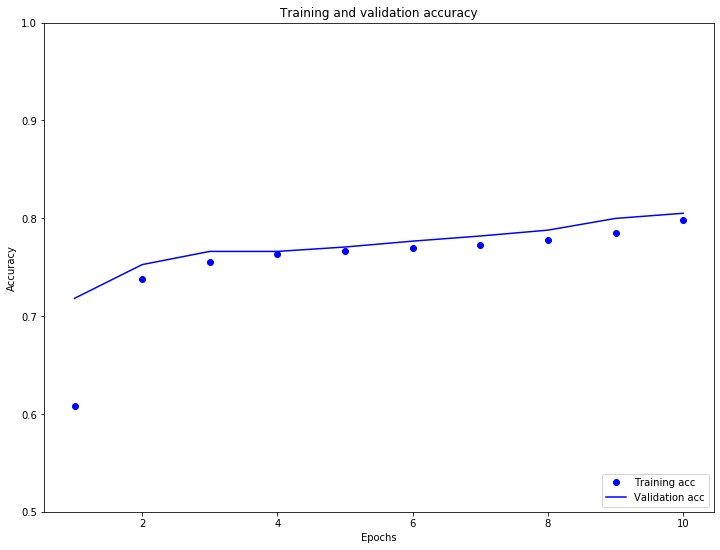

In [28]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

### 4. 活性化関数入れてみる

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(300,)),
    tf.keras.layers.Dense(16, use_bias=True, activation='relu'), # 追加,16はなんとなく4の二乗
    tf.keras.layers.Dense(4, use_bias=True)
])

In [31]:
model.compile(optimizer='SGD',
              loss=loss_fn,
              metrics=['accuracy'])

In [32]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    validation_data=(x_valid, y_valid)
)

Epoch 1/10
334/334 [==============================] - 0s 956us/step - loss: 1.2640 - accuracy: 0.6022 - val_loss: 1.0798 - val_accuracy: 0.7264
Epoch 2/10
334/334 [==============================] - 0s 681us/step - loss: 1.0570 - accuracy: 0.7316 - val_loss: 0.9599 - val_accuracy: 0.7624
Epoch 3/10
334/334 [==============================] - 0s 682us/step - loss: 0.9525 - accuracy: 0.7555 - val_loss: 0.8581 - val_accuracy: 0.7714
Epoch 4/10
334/334 [==============================] - 0s 655us/step - loss: 0.8462 - accuracy: 0.7624 - val_loss: 0.7813 - val_accuracy: 0.7744
Epoch 5/10
334/334 [==============================] - 0s 679us/step - loss: 0.7652 - accuracy: 0.7746 - val_loss: 0.7274 - val_accuracy: 0.7759
Epoch 6/10
334/334 [==============================] - 0s 721us/step - loss: 0.7190 - accuracy: 0.7746 - val_loss: 0.6896 - val_accuracy: 0.7781
Epoch 7/10
334/334 [==============================] - 0s 685us/step - loss: 0.6871 - accuracy: 0.7720 - val_loss: 0.6613 - val_accuracy:

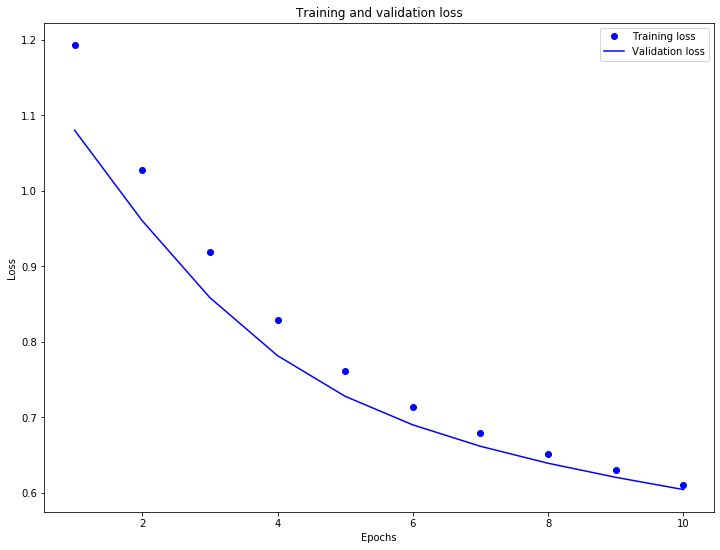

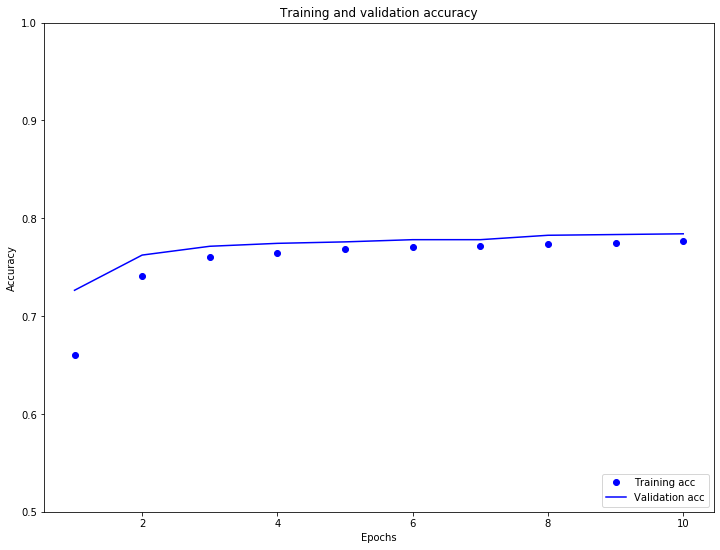

In [33]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

* この中だと、「3. 多層化」が一番精度が良い